# SVM

Documentação:
- https://scikit-learn.org/stable/modules/svm.html#svc
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$



In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ipywidgets import interact, FloatLogSlider
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

def plot_data(X, y, model=None, heatmap=False, margin=True, support=True, errors=False,
              legend=True, colors=['bo','rx','gd','ms','c^','yP'], N=100, gap=1e-9):
    '''Plot 1-D or 2-D classification dataset and classifier decision regions'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = list(np.unique(y))
    if model is not None:
        assert set(classes) <= set(model.classes_)
        classes = list(model.classes_)
    assert len(classes) <= len(colors)
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i]], np.zeros(np.sum(y == classes[i])), colors[i], label=classes[i])
        plt.gca().axes.get_yaxis().set_ticks([])
        plt.xlabel('x')
    else:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i], 0], X[y == classes[i], 1], colors[i], label=classes[i])
        plt.xlabel('x1')
        plt.ylabel('x2')
    if legend:
        plt.legend()
    if model is None:
        return
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, N), np.linspace(x2_min, x2_max, N2))
    if dim == 1:
        XX = np.c_[xx1.reshape(-1)]
    else:
        XX = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    if errors:
        err = model.predict(X) != y
        vert = X[err, 1] if dim == 2 else np.zeros(np.sum(err))
        plt.plot(X[err, 0], vert, 'ks', mfc='none', markersize=10)
    if len(classes) > 2:
        y_pred = model.predict(XX)
        y_pred = np.array([classes.index(a) for a in y_pred])
        y_pred = y_pred.reshape(xx1.shape)
        levels = np.arange(len(classes) + 1) - 0.5
        plt.contour(xx1, xx2, y_pred, levels, colors='k', linewidths=1)
        plt.contourf(xx1, xx2, y_pred, levels, colors=[c[0] for c in colors], alpha=0.25)
        return
    if hasattr(model, 'predict_proba'):
        p = model.predict_proba(XX)[:,1].reshape(xx1.shape)
        plt.contour(xx1, xx2, p, levels=[0.5], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, p, levels=[-np.inf, 0.5, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if heatmap:
            plt.contourf(xx1, xx2, p, levels=100, cmap='bwr', vmin=-1, vmax=2)
    else:
        z = model.decision_function(XX).reshape(xx1.shape)
        plt.contour(xx1, xx2, z, levels=[0], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, z, levels=[-np.inf, 0, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if margin:
            plt.contourf(xx1, xx2, z, levels=[-1, 0, 1], cmap='bwr', vmin=-3, vmax=3)
        if heatmap:
            a = np.max(np.abs(z))*2
            plt.contourf(xx1, xx2, z, 100, cmap='bwr', vmin=-a, vmax=a)
        if support and hasattr(model, 'support_'):
            S = X[model.support_]
            if dim == 1:
                S = np.c_[S, np.zeros(S.shape[0])]
            plt.plot(*S.T, 'go', mfc='none', ms=12)
    return

## SVM linear


(100, 2) (100,)


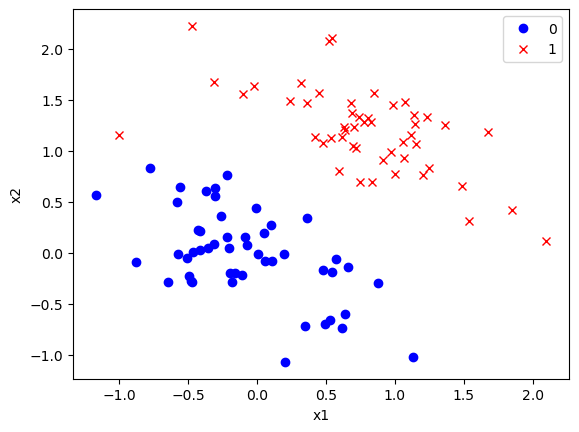

In [39]:
X, y = make_blobs(n_samples=100, n_features=2, centers=[[0,0],[0,1]], cluster_std=0.2, random_state=14)
X = X @ np.array([[2, -2], [1, 1]])
X[52] = [-1, 1.15]
plot_data(X, y)
print(X.shape, y.shape)

Train accuracy: 99.0%


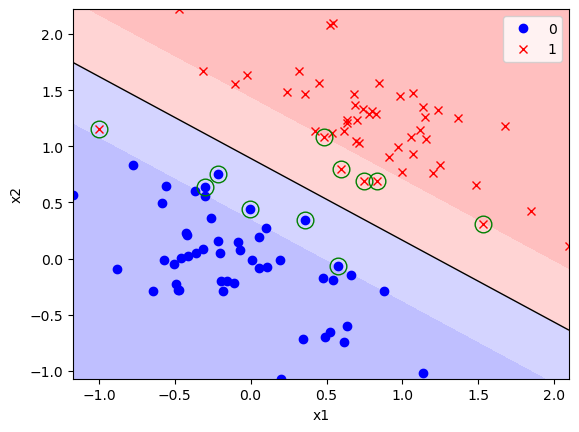

In [40]:
#usar svc apenas para outros kernel, para o linear usar linear-svc
from sklearn.svm import SVC
model = SVC(C=1, kernel='linear')
model.fit(X, y)
print(f'Train accuracy: {model.score(X, y):.1%}')
plot_data(X, y, model)

Os círculos no gráfico acima marcam os **vetores de suporte**. Note que, no classificador SVM, o classificador é definido exclusivamente a partir dos vetores de suporte, i.e., as demais amostras de treinamento que satisfazem a margem não tem impacto no classificador.

### Parâmetros do modelo

- Vetores de suporte

In [41]:
model.support_vectors_

array([[ 0.3600045 ,  0.34393961],
       [-0.00637621,  0.44018784],
       [-0.21599232,  0.75778004],
       [ 0.57512285, -0.0647333 ],
       [-0.30160732,  0.63609011],
       [ 0.59759002,  0.7984996 ],
       [-1.        ,  1.15      ],
       [ 0.74961038,  0.6883295 ],
       [ 0.48109175,  1.07979242],
       [ 1.53399972,  0.31165178],
       [ 0.83561357,  0.69466833]])

- Índices dos vetores de suporte (no conjunto de treinamento)

In [42]:
model.support_

array([ 9, 32, 53, 73, 89, 12, 52, 60, 62, 82, 83])

In [43]:
np.all(X[model.support_] == model.support_vectors_)

True

- Vetor de coeficientes da solução dual ($\alpha_i y_s^{(i)}$)

Obs: $\alpha_i = |\alpha_i y_s^{(i)}|$

Obs: $\alpha_i \neq 0 \iff x^{(i)}$ é um vetor de suporte

In [44]:
model.dual_coef_

array([[-1.        , -1.        , -1.        , -0.66071528, -1.        ,
         1.        ,  1.        ,  1.        ,  0.593429  ,  0.06728628,
         1.        ]])

- Vetor de pesos (da solução primal):

$
\bw = \displaystyle\sum_{i \in \calS} \alpha_i y_s^{(i)} \bx^{(i)}
$

onde $\calS$ denota o conjunto de índices dos vetores de suporte

In [45]:
w = model.dual_coef_ @ model.support_vectors_
print(w)

[[1.3555038  1.85802013]]


In [46]:
model.coef_

array([[1.3555038 , 1.85802013]])

- Termo de *bias*:

$
b = y_s^{(i^*)} - \bw^T \bx^{(i^*)}
$

onde $i^* \in \calS$ denota qualquer índice tal que $0 < \alpha_{i^*} < C$

In [47]:
support_subset = np.where(np.abs(model.dual_coef_.reshape(-1)) < model.C)[0]
support_subset

array([3, 8, 9], dtype=int64)

In [48]:
model.support_[support_subset]

array([73, 62, 82])

In [49]:
b_mean = 0
for i in model.support_[support_subset]:
    b = (2*y[i]-1) - w@X[i]
    print(b)
    b_mean += b
b_mean /= len(support_subset)
print('b_mean:', b_mean)

[-1.65930544]
[-1.65839775]
[-1.65839773]
b_mean: [-1.65870031]


In [50]:
model.intercept_

array([-1.65870033])

### Implementação alternativa: LinearSVC

Se desejamos usar um SVM linear, geralmente é mais interessante usar o modelo [`sklearn.svm.LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html), o qual possui uma implementação otimizada. De acordo com a documentação:

> *Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.*

Nesse caso, o modelo armazena apenas a solução primal, de forma que os parâmetros `.support_`, `.support_vectors` e `.dual_coef_` não estão disponíveis.

Train accuracy: 99.0%


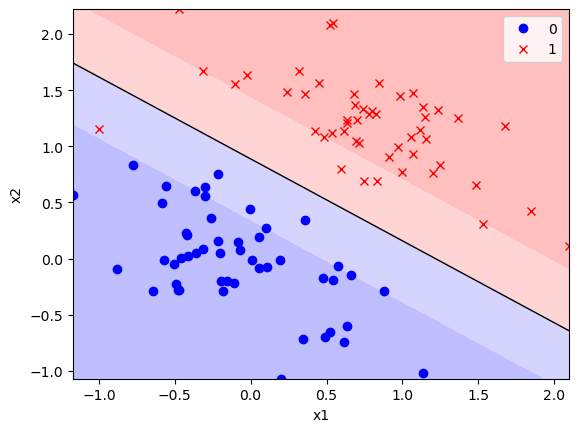

In [51]:
from sklearn.svm import LinearSVC

model = LinearSVC(loss='hinge', C=1)  # default loss is 'squared_hinge'
model.fit(X, y)
print(f'Train accuracy: {model.score(X, y):.1%}')
plot_data(X, y, model)

In [52]:
model.coef_

array([[1.34389782, 1.84213966]])

### Escala dos atributos

In [53]:
scaling = [[0.1, 10], [1, 1], [10, 0.1]]
@interact(scale_data=False)
def _(scale_data):
    plt.figure(figsize=(20,4))
    for i in range(len(scaling)):
        plt.subplot(1, len(scaling), i+1)
        X_scaled = X @ np.diag(scaling[i])
        model = SVC(C=1, kernel='linear')
        model = make_pipeline(StandardScaler() if scale_data else None,
                              SVC(C=1, kernel='linear'))
        model.fit(X_scaled, y)
        plt.title(f'scaling = {scaling[i]}   (accuracy: {model.score(X_scaled, y):.1%})')
        plot_data(X_scaled, y, model)

interactive(children=(Checkbox(value=False, description='scale_data'), Output()), _dom_classes=('widget-intera…

### Variando $C$

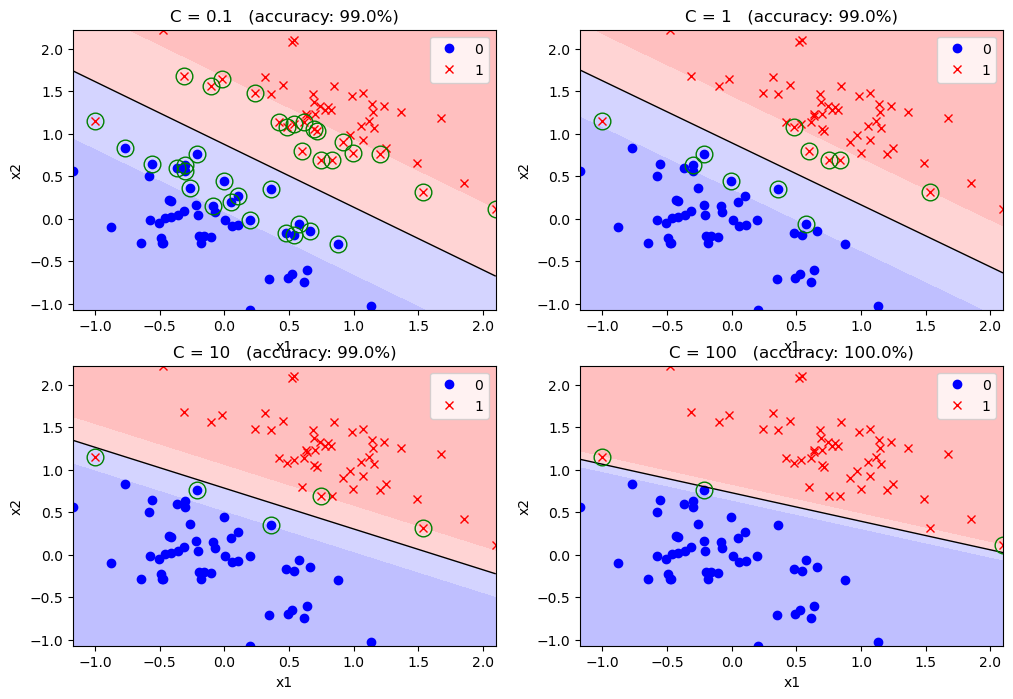

In [55]:
plt.figure(figsize=(12, 8))
for i, C in enumerate([0.1, 1, 10, 100]):
    plt.subplot(2, 2, i+1)
    model = SVC(C=C, kernel='linear')
    model.fit(X, y)
    plt.title(f'C = {C}   (accuracy: {model.score(X, y):.1%})')
    plot_data(X, y, model)

## SVM com kernel RBF (gaussiano)

De maneira geral, um kernel pode ser interpretado como uma função que mede a **similaridade** entre um par de amostras ($\bx^{(i)}$, $\bx^{(j)}$). No caso do kernel RBF, a similaridade é definida como uma função da distância euclidiana entre as amostras, mais precisamente:

$$ K_{\text{RBF}} \left( \bx^{(i)}, \bx^{(j)} \right) = \exp \left( - \gamma \| \bx^{(i)} - \bx^{(j)}\|^2 \right) $$

O parâmetro $\gamma$ (um **hiperparâmetro** do modelo) determina quão rápido a similaridade decai com a distância.

Em contraste, o kernel linear não possui hiperparâmetros, sendo definido simplesmente como o produto interno entre amostras:

$$ K_{\text{linear}} \left( \bx^{(i)}, \bx^{(j)} \right) = {\bx^{(i)}}^T \bx^{(j)} $$

O uso do kernel linear resulta no classificador linear visto anteriormente.

Em qualquer caso, a função de decisão (score de confiança) é dada por
$$
z = \bw^T \bx + b =b + \sum_{i \in \calS} \alpha_i y_s^{(i)} K(\bx^{(i)},\bx)
$$
onde $\calS$ denota o conjunto de índices dos vetores de suporte. Portanto, a predição é realizada calculando o kernel somente com relação aos vetores de suporte, i.e., apenas a similaridade com relação aos vetores de suporte é relevante.

In [58]:
#gaussiana montanha vs vale
@interact(C=FloatLogSlider(value=1e4, min=-6, max=9, step=0.5, readout_format='.2e'), 
          gamma=FloatLogSlider(value=1e-1, min=-6, max=3, step=0.1, readout_format='.2e'), heatmap=False, support_vectors=True)
def _(C, gamma, heatmap, support_vectors):
    model = SVC(C=C, kernel='rbf', gamma=gamma)
    model.fit(X, y)
    plt.title(f'C = {C:.2e}, γ = {gamma:.2e}   (accuracy: {model.score(X, y):.1%})')
    plot_data(X, y, model, heatmap=heatmap, support=support_vectors)

interactive(children=(FloatLogSlider(value=10000.0, description='C', max=9.0, min=-6.0, readout_format='.2e', …

## Outros kernels

- Para kernel polinomial, defina os parâmetros `degree=d`, `gamma='auto'`, `coef0=1` e varie `C` e `d`.

In [59]:
@interact(C=FloatLogSlider(value=1e6, min=-6, max=6, step=0.5, readout_format='.2e'), d=(1, 10, 1), heatmap=False, support_vectors=True)
def _(C, d=1, heatmap=False, support_vectors=True):
    model = SVC(C=C, kernel='poly', degree=d, gamma='auto', coef0=1)
    model.fit(X, y)
    plt.title(f'C = {C:.2e}, d = {d}   (accuracy: {model.score(X, y):.1%})')
    plot_data(X, y, model, heatmap=heatmap, support=support_vectors)

interactive(children=(FloatLogSlider(value=1000000.0, description='C', max=6.0, min=-6.0, readout_format='.2e'…

## Otimização de hiperparâmetros

In [60]:
del X, y

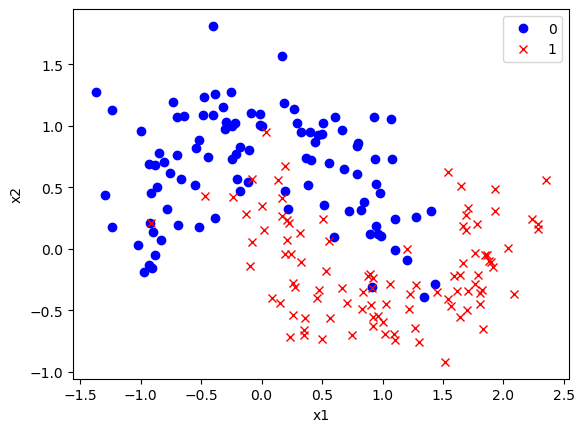

In [61]:
from sklearn.datasets import make_moons
np.random.seed(2019*2)
X_train, y_train = make_moons(n_samples=200, noise=0.25)
X_val,   y_val   = make_moons(n_samples=200, noise=0.25)
X_test,  y_test  = make_moons(n_samples=10000, noise=0.25)
plot_data(X_train, y_train)

**Exercício:** Variando `C` e `gamma`, tente encontrar uma configuração que forneça a explicação aparentemente mais "natural" possível para os dados de treinamento.

In [63]:
@interact(C=FloatLogSlider(value=10, min=-6, max=9, step=0.5, readout_format='.2e'), 
          gamma=FloatLogSlider(value=1, min=-6, max=3, step=0.1, readout_format='.2e'), heatmap=False, support_vectors=False)
def _(C, gamma, heatmap, support_vectors):
    model = SVC(C=C, kernel='rbf', gamma=gamma)
    model.fit(X_train, y_train)
    plt.title(f'C = {C:.2e}, γ = {gamma:.2e}   (accuracy: {model.score(X_train, y_train):.1%})')
    plot_data(X_train, y_train, model, heatmap=heatmap, support=support_vectors)

interactive(children=(FloatLogSlider(value=10.0, description='C', max=9.0, min=-6.0, readout_format='.2e', ste…

### Grid search + Validação hold-out

Agora, sua tarefa é determinar a melhor configuração de hiperparâmetros de acordo com o desempenho no conjunto de validação. Em outras palavras, você deve variar $C$ e $\gamma$, sempre treinando o modelo no conjunto de treinamento e medindo o desempenho no conjunto de validação, até encontrar os valores que maximizam a acurácia de validação.

Para isso, você pode definir uma lista de valores de $C$ (digamos, `list_C`) e uma lista de valores de $\gamma$ (digamos, `list_gamma`), e variar $(C,\gamma)$ dentro da grade `list_C` x `list_gamma` (este método é conhecido como [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search)), o que a princípio poderia ser implementado com dois laços `for`. No entanto, para facilitar, usaremos a função `grid_search` fornecida abaixo, a qual internamente utiliza a função `GridSearchCV` da biblioteca `sklearn`, com a opção `cv=PredefinedSplit()`.

**Obs:** Se o melhor valor encontrado para um hiperparâmetro está na extremidade da faixa de busca, é recomendável estender a faixa.

In [64]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
def grid_search(model, param_grid, X_train, y_train, X_val, y_val):
    val_index = [-1]*len(X_train) + [0]*len(X_val)
    gs = GridSearchCV(model, param_grid, refit=False, cv=PredefinedSplit(val_index))
    gs.fit(np.r_[X_train, X_val], np.r_[y_train, y_val])
    return gs

In [66]:
param_grid = {'C':     10.0**np.arange(-3, 3.01, 1), 
              'gamma': 10.0**np.arange(-3, 3.01, 1)}
gs = grid_search(SVC(kernel='rbf'), param_grid, X_train, y_train, X_val, y_val)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

best_score: 0.96
best_params: {'C': 10.0, 'gamma': 1.0}


In [68]:
param_grid

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [69]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
38,0.000000,0.0,0.002093,0.0,100.0,1.0,"{'C': 100.0, 'gamma': 1.0}",0.960,0.960,0.0,1
31,0.000000,0.0,0.002104,0.0,10.0,1.0,"{'C': 10.0, 'gamma': 1.0}",0.960,0.960,0.0,1
18,0.000000,0.0,0.000000,0.0,0.1,10.0,"{'C': 0.1, 'gamma': 10.0}",0.955,0.955,0.0,3
25,0.000000,0.0,0.000000,0.0,1.0,10.0,"{'C': 1.0, 'gamma': 10.0}",0.950,0.950,0.0,4
45,0.002098,0.0,0.000000,0.0,1000.0,1.0,"{'C': 1000.0, 'gamma': 1.0}",0.950,0.950,0.0,4


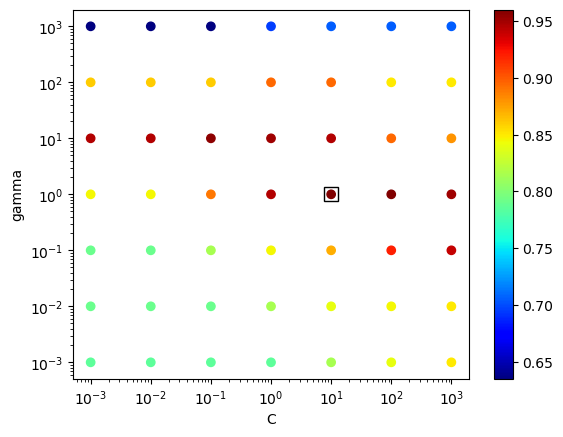

In [70]:
plt.scatter(gs.cv_results_['param_C'], gs.cv_results_['param_gamma'], c=gs.cv_results_['mean_test_score'], cmap='jet');
plt.plot(gs.best_params_['C'], gs.best_params_['gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

Busca mais fina em torno da melhor configuração encontrada:

best_score: 0.965
best_params: {'C': 3.24593634702017, 'gamma': 4.6415888336127775}


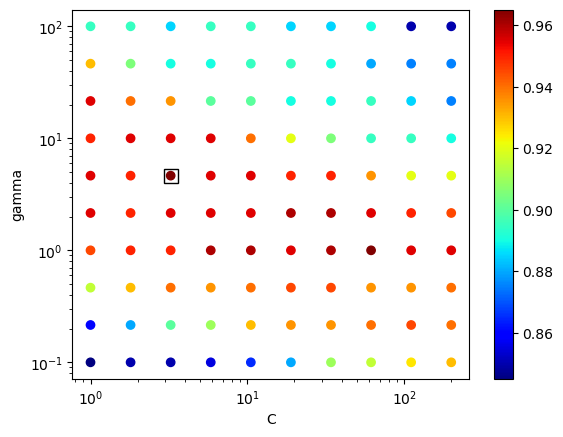

In [71]:
param_grid = {'C':     np.geomspace(1, 200, 10), 
              'gamma': np.geomspace(0.1, 100, 10)}
gs = grid_search(SVC(kernel='rbf'), param_grid, X_train, y_train, X_val, y_val)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

plt.scatter(gs.cv_results_['param_C'], gs.cv_results_['param_gamma'], c=gs.cv_results_['mean_test_score'], cmap='jet');
plt.plot(gs.best_params_['C'], gs.best_params_['gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

Train accuracy: 93.0%
  Val accuracy: 96.5%
 Test accuracy: 93.2%


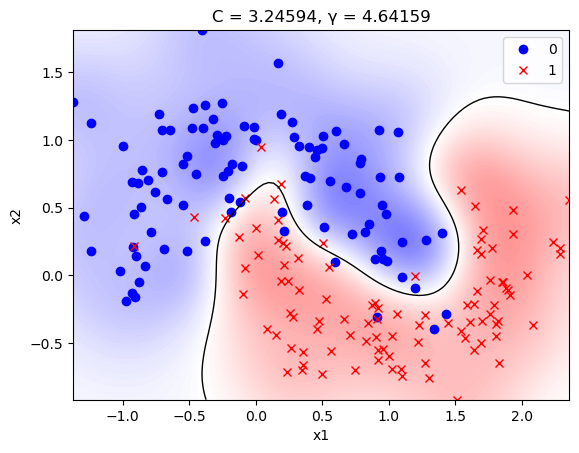

In [73]:
#OF nao se observa, treino prox a teste
#OF na otimizacao dos hiperparametros
C, gamma = gs.best_params_['C'], gs.best_params_['gamma']
model = SVC(C=C, kernel='rbf', gamma=gamma)
model.fit(X_train, y_train)
print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')
print(f' Test accuracy: {model.score(X_test, y_test):.1%}')
plt.title(f'C = {C:g}, γ = {gamma:g}')
plot_data(X_train, y_train, model, heatmap=True, support=False)

- Quando o conjunto de validação é usado para selecionar hiperparâmetros, sua estimativa de desempenho torna-se menos confiável.

### Validação cruzada $k$-fold

Quando o conjunto de dados é pequeno, pode não ser interessante separar um conjunto de validação *hold-out*, porque mesmo este subconjunto de validação pode ainda ser muito pequeno para uma estimativa confiável. Por outro lado, se separarmos uma proporção grande para validação, estaremos reduzindo severamente o número de amostras de treinamento, possivelmente comprometendo o desempenho do modelo.

Nessa situação, pode-se obter um bom *tradeoff* entre a qualidade do modelo e a qualidade da estimativa de desempenho do modelo (ao custo de maior esforço computacional) usando a abordagem conhecida como **validação cruzada $k$-fold**: particionar os dados em $k$ partes e realizar $k$ treinamentos e testes, sempre testando em uma das partes um modelo treinado com as partes restantes. A estimativa de desempenho é a média de todos os testes. A comparação entre o desempenho médio e o desempenho em cada fold nos fornece uma ideia da variabilidade/incerteza da estimativa.

Especificamente, suponha que as amostras em `X_val` e `y_val` não existem. Ainda assim é possível obter uma boa estimativa de desempenho---sem usar o conjunto de teste---e utilizá-la para a escolha de hiperparâmetros, utilizando validação cruzada $k$-fold.

In [74]:
X_val, y_val = None, None

In [75]:
from sklearn.model_selection import cross_val_score
C = 1
gamma = 1
model = SVC(C=C, kernel='rbf', gamma=gamma)
val_acc = cross_val_score(model, X_train, y_train, cv=5)
print(val_acc)
print(f'Mean (5-fold) val accuracy: {np.mean(val_acc):.1%} (std = {np.std(val_acc):.1%})')

[0.975 0.9   0.825 0.925 0.925]
Mean (5-fold) val accuracy: 91.0% (std = 4.9%)


In [76]:
1/40

0.025

### Grid search + Validação cruzada $k$-fold

A estimativa de desempenho via validação cruzada $k$-fold pode ser combinada, por exemplo, com uma busca em grade para determinação de hiperparâmetros; em outras palavras, para cada configuração de hiperparâmetros da grade fornecida, deve-se realizar uma validação cruzada $k$-fold para estimativa de desempenho daquela configuração.

A princípio, isto poderia ser implementado através de laços `for` (para busca em grade) combinados com a função `cross_val_score` para estimativa de desempenho. No entanto, para facilitar, vamos diretamente utilizar a biblioteca `sklearn`, a qual já possui uma implementação eficiente da busca em grade com validação cruzada, mais precisamente a função `sklearn.model_selection.GridSearchCV`. Essa abordagem é, na verdade, a forma mais comum de uso desta função (ao contrário da abordagem *hold-out* via a função `grid_search` fornecida anteriormente).

**Obs:** A opção `refit=True` permite utilizar o próprio objeto `gs = GridSearchCV()` como classificador, com funções `predict`, `score`, etc.

In [77]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':     10.0**np.arange(-3, 3.01, 1), 
              'gamma': 10.0**np.arange(-3, 3.01, 1)}
gs = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
gs.fit(X_train, y_train)
print(gs.best_params_)
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head(5)

{'C': 1000.0, 'gamma': 0.1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
44,0.002052,0.003135,0.000000,0.000000,1000.0,0.1,"{'C': 1000.0, 'gamma': 0.1}",0.975,0.925,0.850,0.900,0.925,0.915,0.040620,1
24,0.000000,0.000000,0.003131,0.006261,1.0,1.0,"{'C': 1.0, 'gamma': 1.0}",0.975,0.900,0.825,0.925,0.925,0.910,0.048990,2
25,0.000000,0.000000,0.000000,0.000000,1.0,10.0,"{'C': 1.0, 'gamma': 10.0}",0.975,0.925,0.850,0.900,0.900,0.910,0.040620,2
38,0.001620,0.003241,0.000419,0.000838,100.0,1.0,"{'C': 100.0, 'gamma': 1.0}",0.975,0.900,0.850,0.900,0.925,0.910,0.040620,2
45,0.004074,0.004989,0.000000,0.000000,1000.0,1.0,"{'C': 1000.0, 'gamma': 1.0}",1.000,0.875,0.850,0.900,0.925,0.910,0.051478,2


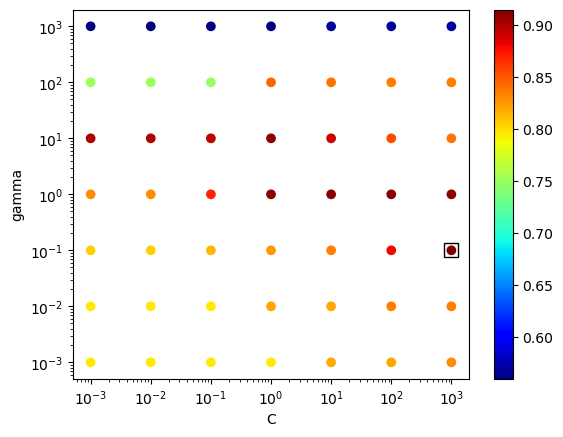

In [78]:
plt.scatter(gs.cv_results_['param_C'], gs.cv_results_['param_gamma'], c=gs.cv_results_['mean_test_score'], cmap='jet');
plt.plot(gs.best_params_['C'], gs.best_params_['gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

Busca mais fina em torno da melhor configuração encontrada:

best_score: 0.9200000000000002
best_params: {'C': 12.599210498948734, 'gamma': 0.7168711644368866}


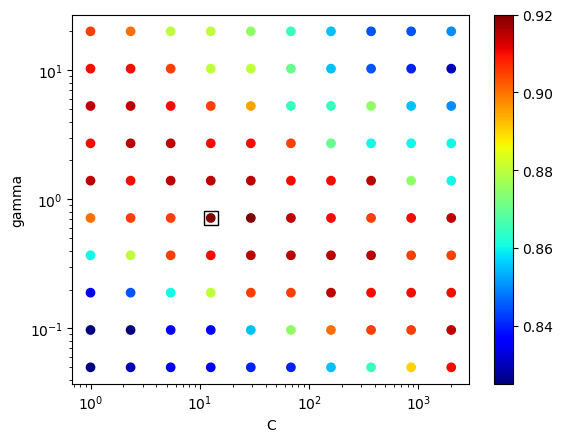

In [79]:
param_grid = {'C':     np.geomspace(1, 2000, 10), 
              'gamma': np.geomspace(0.05, 20, 10)}
gs = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
gs.fit(X_train, y_train)
print('best_score:', gs.best_score_)
print('best_params:', gs.best_params_)

plt.scatter(gs.cv_results_['param_C'], gs.cv_results_['param_gamma'], c=gs.cv_results_['mean_test_score'], cmap='jet');
plt.plot(gs.best_params_['C'], gs.best_params_['gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

In [80]:
gs.best_estimator_

SVC(C=12.599210498948734, gamma=0.7168711644368866)

       Train accuracy: 93.0%
       Train accuracy: 93.0%
Val (5-fold) accuracy: 92.0%
        Test accuracy: 93.6%


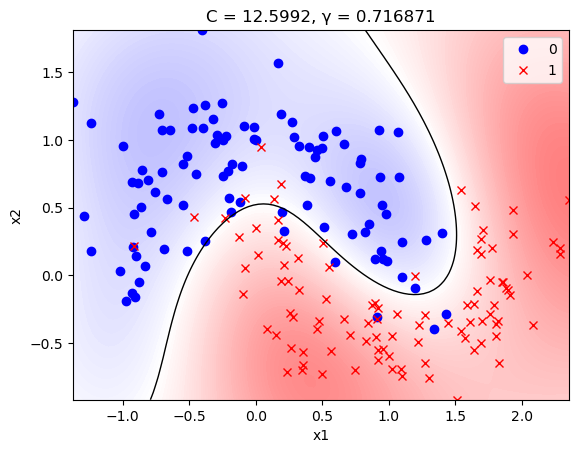

In [81]:
C, gamma = gs.best_params_['C'], gs.best_params_['gamma']
model = SVC(C=C, kernel='rbf', gamma=gamma)
model.fit(X_train, y_train)
print(f'       Train accuracy: {model.score(X_train, y_train):.1%}')
print(f'       Train accuracy: {gs.score(X_train, y_train):.1%}')
print(f'Val (5-fold) accuracy: {gs.best_score_:.1%}')
print(f'        Test accuracy: {model.score(X_test, y_test):.1%}')
plt.title(f'C = {C:g}, γ = {gamma:g}')
plot_data(X_train, y_train, model, heatmap=True, support=False)